# 0.0 Imports

In [14]:
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import yeojohnson
from matplotlib import pyplot as plt
from sklearn import model_selection as ms
from sklearn import preprocessing

## 0.1 Load data

In [15]:
exploratory_data_analysis = catalog.load("exploratory_data_analysis")

[09/22/23 19:59:12] INFO     Loading data from 'exploratory_data_analysis' (CSVDataSet)...      ]8;id=930152;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=544156;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

## 0.2 Helper Functions

In [16]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', exploratory_data_analysis.shape[1])
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.rcParams['font.size'] = 24
    sns.set()

    warnings.filterwarnings('ignore')
    return None


def plot_boxplots(data, n_rows=5, n_cols=5):
    """
    Plots boxplots of all numerical columns in the dataframe.

    Parameters:
    data (DataFrame): Pandas DataFrame to be plotted.
    n_rows (int): Number of rows in the plot grid.
    n_cols (int): Number of columns in the plot grid.

    Returns:
    None
    """
    num_columns = data.select_dtypes(include=['int64', 'float64']).columns
    n = len(num_columns)
    n_figs = math.ceil(n / (n_cols * n_rows))

    for fig_num in range(n_figs):
        plt.figure(figsize=(n_cols * 5, n_rows * 4))
        for i in range(n_rows * n_cols):
            col_index = fig_num * n_cols * n_rows + i
            if col_index < n:  # to avoid trying to access more columns than we have
                plt.subplot(n_rows, n_cols, i+1)
                sns.boxplot(y=data[num_columns[col_index]])
                plt.title(f'Boxplot - {num_columns[col_index]}')
        plt.tight_layout()
        plt.show()


def plot_histograms(data, n_rows=5, n_cols=5):
    """
    Plots histograms of all numerical columns in the dataframe.

    Parameters:
    data (DataFrame): Pandas DataFrame to be plotted.
    n_rows (int): Number of rows in the plot grid.
    n_cols (int): Number of columns in the plot grid.

    Returns:
    None
    """
    num_columns = data.select_dtypes(include=['int64', 'float64']).columns
    n = len(num_columns)
    n_figs = math.ceil(n / (n_cols * n_rows))

    for fig_num in range(n_figs):
        plt.figure(figsize=(n_cols * 5, n_rows * 4))
        for i in range(n_rows * n_cols):
            col_index = fig_num * n_cols * n_rows + i
            if col_index < n:  # to avoid trying to access more columns than we have
                plt.subplot(n_rows, n_cols, i+1)
                col_data = data[num_columns[col_index]]
                plt.hist(col_data, bins=min(30, len(np.unique(col_data))))  # use at most 30 bins, or fewer if fewer unique values
                plt.title(f'Histogram - {num_columns[col_index]}')
        plt.tight_layout()
        plt.show()


notebook_settings()

# 4.0 Data preparation

In [17]:
exploratory_data_analysis.head()

,show_id,title,director,cast,country,date_added,release_year,rating,listed_in,description,minutes,seasons
0,81145628,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,41,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,90,0
1,80117401,Jandino: Whatever it Takes,others_directors,Jandino Asporaat,United Kingdom,2016-09-09,2016,52,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,94,0
2,80125979,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,57,Comedies,When nerdy high schooler Dani finally attracts...,99,0
3,70304989,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada",2017-09-08,2014,61,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",110,0
4,80164077,Fabrizio Copano: Solo pienso en mi,"Rodrigo Toro, Francisco Schultz",Fabrizio Copano,Chile,2017-09-08,2017,49,Stand-Up Comedy,Fabrizio Copano takes audience participation t...,60,0


## 4.1 Split Dataframe into training and validation dataset

In [18]:
exploratory_data_analysis = exploratory_data_analysis.drop(columns=['date_added'])

X = exploratory_data_analysis.drop('rating', axis=1)
y = exploratory_data_analysis['rating'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.20)

train_data = pd.concat([x_train, y_train], axis=1)
validation_data = pd.concat([x_val, y_val], axis=1)

## 4.2 Standardization/Rescaling

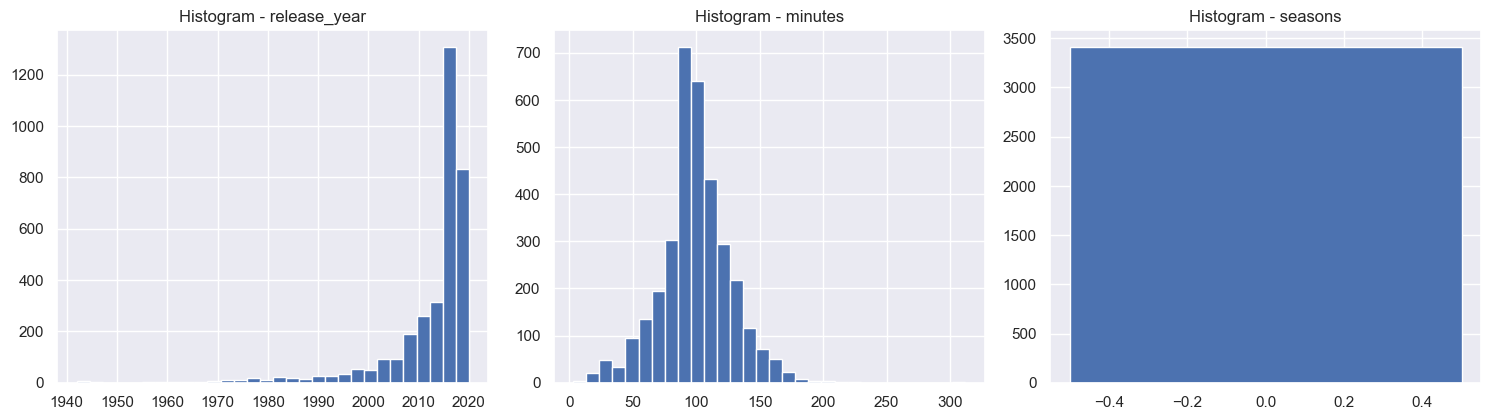

In [19]:
num_attributes = train_data.select_dtypes(include='number')
num_attributes.drop(['show_id', 'rating'], axis=1, inplace=True)
plot_histograms(num_attributes)

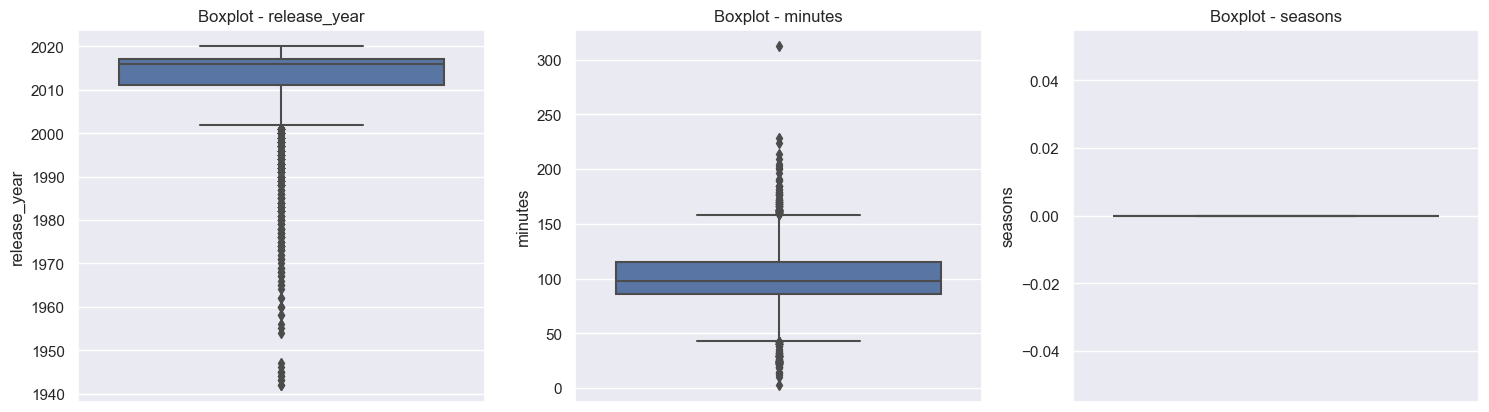

In [20]:
plot_boxplots(num_attributes)

All the features have a pronounced skew, so we will apply rescaling, with year and season using a robust outlier.

In [21]:
rs = preprocessing.RobustScaler()
ss = preprocessing.StandardScaler()

cols_to_standard = ['minutes']
cols_to_robust = ['release_year', 'seasons']

for col in cols_to_standard:
    train_data[col] = ss.fit_transform(train_data[[col]].values)
    validation_data[col] = ss.transform(
        validation_data[[col]].values
    )

for col in cols_to_robust:
    train_data[col] = rs.fit_transform(train_data[[col]].values)
    validation_data[col] = rs.transform(
        validation_data[[col]].values
    )

## 4.3 Transformation

### 4.3.1 Encoding

In [22]:
cols_to_label = ['title', 'director', 'cast',
    'listed_in', 'description']

le = preprocessing.LabelEncoder()

for col in cols_to_label:
    train_data[col] = le.fit_transform(train_data[col])
    # Check if there is something not mapped in validation data
    validation_data[col] = validation_data[col].map(
        lambda s: "unknown" if s not in le.classes_ else s
    )
    # Add the new class 'unknown' if it is not present
    if "unknown" not in list(le.classes_):
        le.classes_ = np.append(le.classes_, "unknown")
    else:
        # The class 'unknown' is already present, ensure that it occurs only once
        le.classes_ = np.unique(le.classes_)
    validation_data[col] = le.transform(validation_data[col])

fe_country = train_data.groupby('country').size() / len(train_data)
train_data.loc[:, 'country'] = train_data['country'].map(fe_country)

validation_data.loc[:, 'country'] = validation_data['country'].map(fe_country)

### 4.3.2 Response Variable Transformation

The prediction of a model can be biased according to the distribution of the response variable, as we analyzed in the exploratory data analysis notebook we need to convert the variable to a normal distribution.

In [23]:
train_data['rating'] = yeojohnson(train_data['rating'])[0]

### 4.3.3 Nature Transformation

Transformation of nature involves maintaining a state and preserving its cycle, for example in numerical terms a column of months the model can understand that month 1 is close to month 2, on the other hand month 1 seems very far from month 12, in this case we will apply techniques that allow the model to understand that both months are very close.

In [24]:
# TODO

In [25]:
catalog.save("train_data_preparation", train_data)
catalog.save("validation_data_preparation", validation_data)

[09/22/23 19:59:13] INFO     Saving data to 'train_data_preparation' (CSVDataSet)...            ]8;id=20963;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=89595;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\

                    INFO     Saving data to 'validation_data_preparation' (CSVDataSet)...       ]8;id=797075;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=948356;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\